In [1]:
import numpy as np
import scipy
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from os import path


In [2]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


In [12]:
import itertools
from operator import add
from quimb import *
import quimb

r=2 # local Hilbert space dim

def ham_chain(L, g=1.0, h=0.0, cyclic=True,
                sparse=True):

# g=0
# h=0
# cyclic=True
# m= 4
    dims = [r] * L  # shape (n, m)

    # generate tuple of all site coordinates
    # sites = tuple(itertools.product(range(n)))
    sites= tuple(range(L))
    # print(sites)

    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i in sites:
    #         print(i)
            right = (i + 1) % L 
            # ignore wraparound coordinates if not cyclic
            if cyclic or right != 0:
                yield (i, right)

    # generate all pairs of coordinates and directions
    pairs_ss = tuple(gen_pairs())
    # pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    print(pairs_ss)
#     print(sites)

    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair):
        Sz = spin_operator('z', sparse=True)
        return ikron([2*Sz, 2*Sz], dims, inds=pair)

    # function to make Z field at ``site``
    def fields(site):
        Sx = spin_operator('x', sparse=True)
        Sz = spin_operator('z', sparse=True)
        return ikron(g * 2*Sx+ h * 2*Sz, dims, inds=[site])

    # combine all terms
    all_terms = itertools.chain(map(interactions, pairs_ss),
                                map(fields, sites))
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real

    if not sparse:
        H = qarray(H.A)
    else:
        H= quimb.core.sparse_matrix(H)

    return H


In [14]:
# chaotic
L = 12
%time H1 = ham_chain(L=L, g=1.05, h=0.5, cyclic=True,sparse=True)
# H1 = ham_chain(L=L, g=1.0, h=0., cyclic=True,sparse=False)
# H1 = ham_ising(L, jz=-4.0, bx=2.0, cyclic=True, parallel=True,sparse=True)
print('Hamiltonian constructed!')

dN = 1

# H2=H1.dot(H1)
%time ge, es= scipy.sparse.linalg.eigsh(H1, k=2*dN, sigma=0, which='LM',tol=1e1)
# %time maxeval = scipy.sparse.linalg.eigsh( H2, k=1 )[0][0]  # biggest, fast
# print('max eval found',maxeval)
# Hflip = maxeval * scipy.sparse.eye(2**L) - H2
# %time ge, es= scipy.sparse.linalg.eigsh(Hflip, k=1, which='LM')


((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 0))
CPU times: user 45.4 ms, sys: 6.97 ms, total: 52.4 ms
Wall time: 49.5 ms
Hamiltonian constructed!
CPU times: user 3min 3s, sys: 9.58 s, total: 3min 12s
Wall time: 16.1 s


In [15]:
# integrable

%time H1_0 = ham_chain(L=L, g=1.05, h=0., cyclic=True,sparse=True)
print('Hamiltonian constructed!')


%time ge0, es0= scipy.sparse.linalg.eigsh(H1_0, k=2*dN, sigma=0, which='LM',tol=1e1)
# H2_0=H1_0.dot(H1_0)
# %time maxeval = scipy.sparse.linalg.eigsh( H2_0, k=1 )[0][0]  # biggest, fast
# print('max eval found',maxeval)
# Hflip_0 = maxeval * scipy.sparse.eye(2**L) - H2_0
# %time ge0, es0= scipy.sparse.linalg.eigsh(Hflip_0, k=2*dN, which='LM')


((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 0))
CPU times: user 51.6 ms, sys: 77 µs, total: 51.7 ms
Wall time: 50 ms
Hamiltonian constructed!
CPU times: user 2min 23s, sys: 7.24 s, total: 2min 31s
Wall time: 12.7 s


In [ ]:
print(ge)
print(es.shape)
# print(H1.shape)

In [16]:

Na=8
Nb = L-Na
# states=np.arange(2**(L-1)-dN,2**(L-1)+dN)
if len(ge)<2*dN:
    states=np.arange(0,len(ge))
else:
    states=np.arange(0,2*dN)

neg_q=np.zeros((int(Na/2)+1,len(states)))
neg_q_0=np.zeros((int(Na/2)+1,len(states)))

dims_a = [r] * Na
dims = [r] * L
N = prod(dims)

t_timer=time.time()
for i_s in range(len(states)):
    print(i_s)#, end='\r')
    st_num= states[i_s]
    psi = es[:,st_num]
    psi_0 = es0[:,st_num]

    for i_n in range(int(Na/2)):
        print(i_n, end='\r')
        Na1= i_n+1
        Na2= Na-i_n-1
        neg_q[i_n+1,i_s]=negativity_subsys_approx(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
#         neg_q[i_n+1,i_s]=logneg_subsys(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
        neg_q_0[i_n+1,i_s]=negativity_subsys_approx(psi_0, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))

elapsed = time.time() - t_timer
print("Finished, quimb elapsed time = %.2f " % (elapsed)+ "sec")

# f1= 'LN_r_%d_NA_%d_NB_%d.npz' % (r,Lab,Lc)
# out_dir = 'LN_figs/' 
# fname = out_dir+f1
# np.savez(fname, logneg=neg_q)
# print(neg_q)

R12_list=np.linspace(0.0,0.499,101)
logneg=np.zeros(len(R12_list))
for i_1 in range(len(R12_list)-1):
    R12=R12_list[i_1+1]
    Lb= r**Nb
    L1= r**(R12*Na)
    L2= r**((1-R12)*Na)

    a = Lb/L2 +1j*0
    b = Lb/L2*L1 +1j*0
    logneg[i_1+1]=np.log2(neg_calc(a,b)*(L2*L1)/pi/(L1*Lb))


0
1
Finished, quimb elapsed time = 10.65 sec


<ipython-input-2-c4c04fc1eabd>:16: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
<ipython-input-2-c4c04fc1eabd>:16: RuntimeWarning: invalid value encountered in cdouble_scalars
  z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


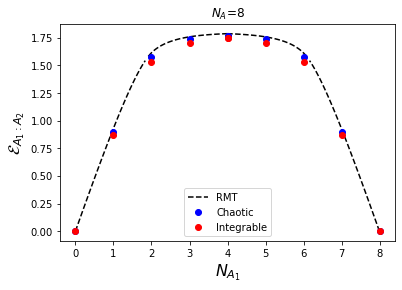

In [17]:
# f1= 'LN_r_%d_NA_%d_NB_%d.npz' % (r,Lab,Lc)
# fname = out_dir+f1
# if path.exists(fname):
#     npzfile = np.load(fname)
#     neg_q=npzfile['logneg']
#     print('Averaged over %d reps' % (np.size(neg_q,1)))

plt.plot(R12_list*Na,logneg,'k--')
plt.plot((0.5+R12_list[::-1])*Na,logneg,'k--',label='RMT')

logneg_q_avg=np.log2(2*np.mean(neg_q,axis=1)+1)
logneg_q0_avg=np.log2(2*np.mean(neg_q_0,axis=1)+1)
# logneg_q_avg= np.mean(neg_q,axis=1)

plt.plot(np.arange(0,int(Na)/2+1), logneg_q_avg, 'bo',label='Chaotic')
# plt.plot(np.arange(0,int(Lab)/2+1), neg_q, 'o')
plt.plot(int(Na)/2+np.arange(0,int(Na)/2+1), logneg_q_avg[::-1], 'bo')
plt.plot(np.arange(0,int(Na)/2+1), logneg_q0_avg, 'ro',label='Integrable')
plt.plot(int(Na)/2+np.arange(0,int(Na)/2+1), logneg_q0_avg[::-1], 'ro')

# yplot= np.array([0, 0.8482, 1.2754, 1.5003, 1.5529, 1.5628, 1.5530, 1.5002, 1.2753, 0.8481, 0.0000])/np.log(2)
yplot=[0, 0.9632, 1.8613, 2.5124, 2.6872, 2.7209, 2.6874, 2.5123, 1.8609, 0.9631, 0.0000]
# plt.plot(np.arange(0,11), yplot, 'rx',label='J')

plt.title('$N_A$=%d' % (Na))
plt.xlabel(r'$N_{A_1}$',fontsize=16)
plt.ylabel(r'${\cal E}_{A_1:A_2}$',fontsize=16)

# plt.ylim(0,5.)
# plt.xlim(0,int(Lab)/2+1)
plt.legend()
plt.show()

In [ ]:
print(neg_q)